In [23]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import pandas as pd

def load_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape((num, rows * cols))
        return data.astype(np.float32) / 255.0

def load_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(), dtype=np.uint8)


In [24]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)


In [25]:
def trace_autodiff_example(x1, x2):
    # === Forward Pass (Primal Values) ===
    v1 = x1
    v2 = x2
    v3 = v1 * v2
    v4 = np.sin(v1)
    v5 = v3 + v4
    v6 = np.exp(v5)
    v7 = np.log(v6)

    # === Forward-Mode Autodiff ===
    v1_dot = 1.0  # make x1 delevertive
    v2_dot = 0.0  # assum x2 is constrnt number
    v3_dot = v1_dot * v2 + v1 * v2_dot
    v4_dot = np.cos(v1) * v1_dot
    v5_dot = v3_dot + v4_dot
    v6_dot = np.exp(v5) * v5_dot
    v7_dot = (1 / v6) * v6_dot

    # === Reverse-Mode Autodiff ===
    v7_bar = 1.0
    v6_bar = v7_bar * (1 / v6)
    v5_bar = v6_bar * np.exp(v5)
    v4_bar = v5_bar * 1.0
    v3_bar = v5_bar * 1.0
    v2_bar = v3_bar * v1
    v1_bar = v3_bar * v2 + v4_bar * np.cos(v1)

    # === 整理成追蹤表格 ===
    table = pd.DataFrame({
        "Variable": ["v1", "v2", "v3", "v4", "v5", "v6", "v7"],
        "Primal (v)": [v1, v2, v3, v4, v5, v6, v7],
        "Forward Tangent (ẋ)": [v1_dot, v2_dot, v3_dot, v4_dot, v5_dot, v6_dot, v7_dot],
        "Reverse Adjoint (v̄)": [v1_bar, v2_bar, v3_bar, v4_bar, v5_bar, v6_bar, v7_bar]
    })

    return table


In [26]:
def your_sgd_logistic(X, y, eta, max_iters):
    w = np.zeros(X.shape[1])

    for i in range(max_iters):
        v1 = X.dot(w)
        preds = sigmoid(v1)
        grad = X.T.dot(preds - y) / len(y)

        if i == 0:
            trace = trace_autodiff_example(X[0], w)

        w -= eta * grad

    return w, trace


In [27]:
def show_misclassified(X, y_true, y_pred, max_show=10):
    mis_idx = np.where(y_true != y_pred)[0][:max_show]
    if len(mis_idx) == 0:
        print("No misclassifications!")
        return
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(mis_idx):
        plt.subplot(1, len(mis_idx), i + 1)
        plt.imshow(X[idx, 1:].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"T:{y_true[idx]}\nP:{y_pred[idx]}")
    plt.suptitle("Misclassified Samples")
    plt.show()


In [28]:
def plot_autodiff_traces(trace_df):
    variables = trace_df['Variable']
    primal = trace_df['Primal (v)'].astype(float)
    forward = pd.to_numeric(trace_df['Forward Tangent (ẋ)'], errors='coerce')
    reverse = pd.to_numeric(trace_df['Reverse Adjoint (v̄)'], errors='coerce')

    fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

    ax[0].bar(variables, primal, color='skyblue')
    ax[0].set_ylabel("Primal (v)")
    ax[0].set_title("Primal Values")

    ax[1].bar(variables, forward, color='lightgreen')
    ax[1].set_ylabel("Forward Tangent (ẋ)")
    ax[1].set_title("Forward-Mode Autodiff")

    ax[2].bar(variables, reverse, color='salmon')
    ax[2].set_ylabel("Reverse Adjoint (v̄)")
    ax[2].set_title("Reverse-Mode Autodiff")
    ax[2].set_xlabel("Variables")

    plt.tight_layout()
    plt.show()



Test Accuracy (is digit '8' or not): 0.9269


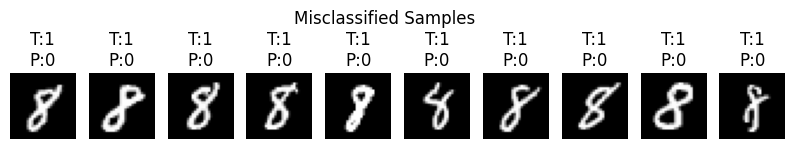


Autodiff Trace Table (v1 ~ v7):
  Variable  Primal (v)  Forward Tangent (ẋ)  Reverse Adjoint (v̄)
0       v1    0.500000             1.000000              2.877583
1       v2    2.000000             0.000000              0.500000
2       v3    1.000000             2.000000              1.000000
3       v4    0.479426             0.877583              1.000000
4       v5    1.479426             2.877583              1.000000
5       v6    4.390423            12.633804              0.227768
6       v7    1.479426             2.877583              1.000000


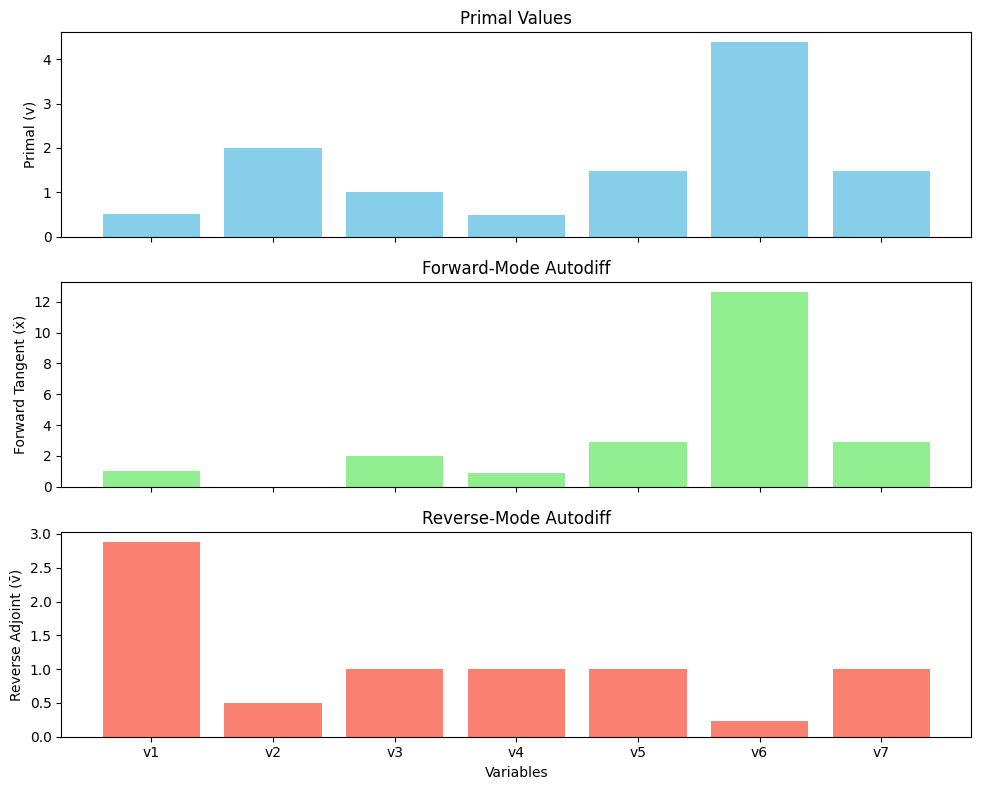

In [29]:
def main():
    # Load MNIST Data
    X_train = load_images("t10k-images.idx3-ubyte_____")
    y_train = load_labels("t10k-labels.idx1-ubyte_____")
    X_test = load_images("train-images.idx3-ubyte_____")
    y_test = load_labels("train-labels.idx1-ubyte_____")

    # Binary Classification
    TARGET_DIGIT = 8  # muj studenti ceslo je 10263008
    y_train_bin = np.where(y_train == TARGET_DIGIT, 1, 0)
    y_test_bin = np.where(y_test == TARGET_DIGIT, 1, 0)

    # === Add Bias ===
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    # === Train Logistic Model via SGD ===
    w, _ = your_sgd_logistic(X_train, y_train_bin, eta=0.1, max_iters=100)

    # === Predict on Test Data ===
    pred_probs = sigmoid(X_test.dot(w))
    preds = (pred_probs >= 0.5).astype(int)

    # === Evaluate Accuracy ===
    acc = np.mean(preds == y_test_bin)
    print(f"\nTest Accuracy (is digit '{TARGET_DIGIT}' or not): {acc:.4f}")

    # === Show Misclassified Samples ===
    show_misclassified(X_test, y_test_bin, preds)

    # === Trace Autodiff from v1 to v7 ===
    print("\nAutodiff Trace Table (v1 ~ v7):")
    autodiff_trace = trace_autodiff_example(0.5, 2.0)  # 可以自行調整輸入值 x1, x2
    print(autodiff_trace)

    # === Plot Trace Graphs ===
    plot_autodiff_traces(autodiff_trace)

if __name__ == "__main__":
    main()